# openEO Platform - Photovoltaic Farms Mapping

In [1]:
import os
import numpy as np
import geopandas as gpd
import leafmap
import openeo
from openeo.processes import lte
import xarray as xr
import matplotlib.pyplot as plt

Load the PV farms geometries returned by Open Street Map for Austria.

In [4]:
pv_geoms = gpd.read_file("./data/shapefiles/photovoltaic.shp")

Filtering by size, keeping only the polygons covering a large area (how to defined "large"?):

In [5]:
threshold_area = 5000 #m^2 ~50mx100m
pv_geoms_32632 = pv_geoms.to_crs(32632)
big_pv_geoms_32632 = pv_geoms_32632.where(pv_geoms_32632["geometry"].area > threshold_area).dropna()
big_pv_geoms = big_pv_geoms_32632.to_crs(4326)
print(f"Number of selected PV Farms: {len(big_pv_geoms)}")

Number of selected PV Farms: 43


Visualize a couple of PV Farms polygons:

In [3]:
m = leafmap.Map(center=[48.087, 14.51], zoom=17,basemap="Esri.WorldImagery")
m.add_gdf(big_pv_geoms, layer_name="PV")
m

Map(center=[48.087, 14.51], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

We would like to understand where the PV farms are located, in particular if they are on grasslands or in built-up areas.

To do so, we download from openEO Platform the land cover/land use layer for each polygon and evaluate it.

We use WorldCover at 10 meter resolution:

1. https://esa-worldcover.org/en
2. https://data.apps.fao.org/catalog/dataset/8cf69f76-1be0-4339-a0b0-18a93c7f4760
3. https://worldcover2021.esa.int/

In [7]:
conn = openeo.connect("openeo.cloud").authenticate_oidc()

Authenticated using refresh token.


In [ ]:
## Download LCLU Maps
for i, geom in big_pv_geoms_32632.iterrows():

    if os.path.exists(f"./data/lclu/lclu_2021_{i}.nc"):
        continue
    
    # Apply a buffer of 20 meters around our PV farm polygon to get some pixels around it, useful for later.
    aoi = np.round(geom["geometry"].buffer(20).bounds,-1)
    collection = "ESA_WORLDCOVER_10M_2021_V2"
    
    spatial_extent = {"west": aoi[0],
                      "east": aoi[2],
                      "south": aoi[1],
                      "north": aoi[3],
                     "crs":"EPSG:32632"}
    
    lclu_bands = ["MAP"]
    
    lclu_cube = conn.load_collection(
        collection,
        spatial_extent = spatial_extent,
        bands = lclu_bands,
    )
    
    try:
        lclu_cube.download(f"./data/lclu/lclu_2021_{i}.nc")
    except:
        continue
    

In [12]:
lclu_dict = {10:"Tree cover", 20:"Shrubland", 30:"Grassland",
            40:"Cropland", 50:"Built-up", 60:"Bare / sparse vegetation",
            70:"Snow and Ice", 80:"Permanent water bodies", 90:"Herbaceous Wetland",
            95:"Mangrove" , 100:"Moss and lichen"}

Map each polygon with its corresponding class:

In [10]:
from scipy.stats import mode
LCLU_values = []
ids = []
for i, geom in big_pv_geoms_32632.iterrows():
    if os.path.exists(f"./data/lclu/lclu_2021_{i}.nc"):

        data = xr.open_dataset(f"./data/lclu/lclu_2021_{i}.nc",decode_coords="all")
        
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        clipped = data.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)
        arr = clipped.to_array().values.ravel()
        
        result = mode(arr, nan_policy = 'omit')
        mode_value = int(result.mode)
        LCLU_values.append(mode_value)
        ids.append(i)

In [13]:
big_pv_geoms_32632['land_cover'] = LCLU_values
big_pv_geoms_32632['land_cover'] = big_pv_geoms_32632['land_cover'].map(lclu_dict)
big_pv_geoms_32632.head(5)

,id,geometry,land_cover
1,1.0,"POLYGON ((822310.925 5186627.453, 822274.692 5...",Grassland
9,9.0,"POLYGON ((564230.921 5231117.798, 564270.245 5...",Grassland
31,31.0,"POLYGON ((1017573.230 5195699.612, 1017475.496...",Grassland
101,101.0,"POLYGON ((926647.803 5240659.558, 926591.791 5...",Grassland
102,102.0,"POLYGON ((555566.174 5264751.447, 555586.562 5...",Built-up


Plot the land cover distribution among our samples:

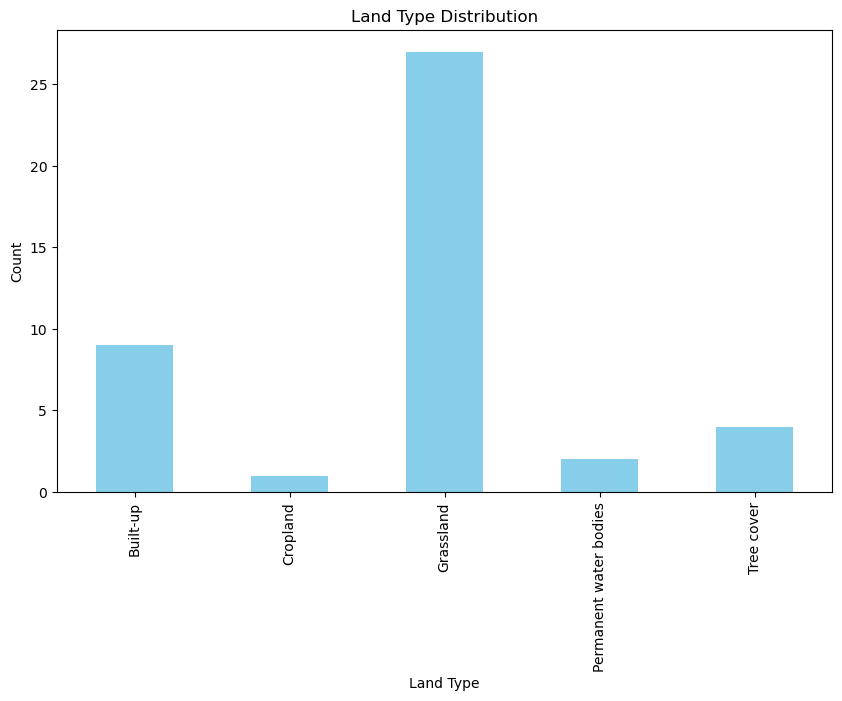

In [15]:
# Count the occurrences of each land type
land_type_counts = big_pv_geoms_32632['land_cover'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
land_type_counts.sort_index().plot(kind='bar', color='skyblue')
plt.title('Land Type Distribution')
plt.xlabel('Land Type')
plt.ylabel('Count')
plt.show()

We notice that there might be PV farms on water, we can investigate further:

#### Plot PVs over water

In [14]:
big_pv_geoms_water = big_pv_geoms_32632[big_pv_geoms_32632['land_cover']=='Permanent water bodies']
big_pv_geoms_water = big_pv_geoms_water.to_crs(4326)
big_pv_geoms_water['centroid'] = big_pv_geoms_water['geometry'].centroid
big_pv_geoms_water

,id,geometry,land_cover,centroid
1913,1919.0,"POLYGON ((15.76669 48.42499, 15.76896 48.42475...",Permanent water bodies,POINT (15.76969 48.42390)
1933,1939.0,"POLYGON ((15.76434 48.42046, 15.77259 48.42003...",Permanent water bodies,POINT (15.76839 48.41961)


In [15]:
## Plot over water
m = leafmap.Map(center=[48.42390, 15.76969], zoom=17,basemap="Esri.WorldImagery")
m.add_gdf(big_pv_geoms, layer_name="PV")
m

Map(center=[48.4239, 15.76969], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

SentinelHub Viewer: https://apps.sentinel-hub.com/sentinel-playground/?source=S2L2A&lat=48.422244752413604&lng=15.768899917602539&zoom=16&preset=1_TRUE_COLOR&layers=B01,B02,B03&maxcc=20&gain=1.0&gamma=1.0&time=2023-05-01%7C2023-11-29&atmFilter=&showDates=false

#### Plot PVs over Built-up area 


In [16]:
big_pv_geoms_built = big_pv_geoms_32632[big_pv_geoms_32632['land_cover']=='Built-up']
big_pv_geoms_built = big_pv_geoms_built.to_crs(4326)
big_pv_geoms_built['centroid'] = big_pv_geoms_built['geometry'].centroid
big_pv_geoms_built

,id,geometry,land_cover,centroid
102,102.0,"POLYGON ((9.73827 47.53381, 9.73854 47.53362, ...",Built-up,POINT (9.73851 47.53316)
398,398.0,"POLYGON ((15.76830 46.71420, 15.76807 46.71479...",Built-up,POINT (15.76935 46.71482)
435,435.0,"POLYGON ((16.73130 48.02250, 16.73434 48.02241...",Built-up,POINT (16.73416 48.02227)
454,454.0,"POLYGON ((16.59158 47.81134, 16.59253 47.81133...",Built-up,POINT (16.59205 47.81096)
684,684.0,"POLYGON ((13.50710 46.73196, 13.50732 46.73080...",Built-up,POINT (13.50669 46.73128)
819,819.0,"POLYGON ((14.99618 47.07197, 14.99682 47.07200...",Built-up,POINT (14.99566 47.07132)
915,915.0,"POLYGON ((16.40882 48.13156, 16.41218 48.13103...",Built-up,POINT (16.41034 48.13084)
1285,1285.0,"POLYGON ((15.07408 48.52706, 15.07410 48.52669...",Built-up,POINT (15.07371 48.52663)
2008,2014.0,"POLYGON ((15.90196 46.76300, 15.90163 46.76372...",Built-up,POINT (15.90440 46.76317)


In [17]:
## Plot over built-up area
m = leafmap.Map(center=[47.53316, 9.73851], zoom=17,basemap="Esri.WorldImagery")
m.add_gdf(big_pv_geoms, layer_name="PV")
m

Map(center=[47.53316, 9.73851], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

Download the Sentinel-2 data with openEO Platform for each polygon (only for grassland class?):

In [4]:
conn = openeo.connect("openeo.cloud").authenticate_oidc()

Authenticated using refresh token.


In [5]:
for i, geom in big_pv_geoms_32632.iterrows():
    if os.path.exists(f"./data/netcdfs/S2_2022_{i}.nc"):
        continue
    print(i)
    print(geom["geometry"])
    aoi = np.round(geom["geometry"].buffer(20).bounds,-1)
    collection = "SENTINEL2_L2A"
    spatial_extent = {"west": aoi[0],
                      "east": aoi[2],
                      "south": aoi[1],
                      "north": aoi[3],
                     "crs":"EPSG:32632"}
    temporal_extent = ["2022-01-01","2022-12-31"]
    all_bands = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B11","B12","SCL"]
    properties={"eo:cloud_cover": lambda x: lte(x, 50)}
    
    s2_cube = conn.load_collection(
        collection,
        temporal_extent = temporal_extent,
        spatial_extent = spatial_extent,
        bands = all_bands,
        properties = properties
    )
    try:
        s2_cube.download(f"./data/netcdfs/S2_2022_{i}.nc")
    except:
        continue

Have a look at the signal from a single PV farm:

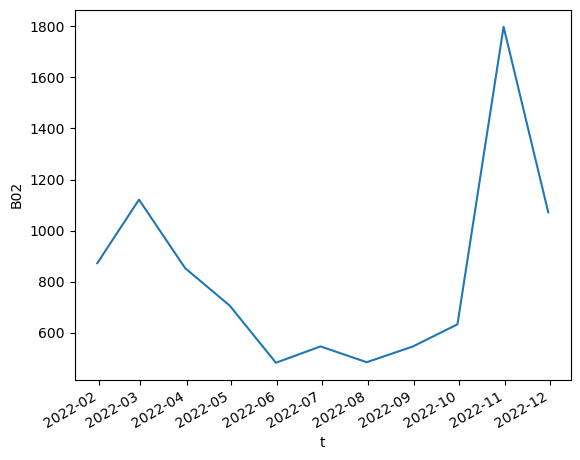

In [23]:
for i, geom in big_pv_geoms_32632.iterrows():
    if i==813: # Showing the plot for an area I'm pretty sure it's covered by PV Panels
        if not os.path.exists(f"./data/netcdfs/S2_2022_{i}.nc"):
            continue
        data = xr.open_dataset(f"./data/netcdfs/S2_2022_{i}.nc",decode_coords="all")
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        clipped = data.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)
        clipped = clipped.where(~cloud_mask)
        # Computing the mean over the area which should be covered by the panels. Other statistics can be computed
        #Resampling to weekly, maybe required to align different time series
        aoi_mean = clipped.mean(dim=["x","y"],skipna=True).resample({"t": "M"}).mean()
        aoi_mean.B02.plot()
        break

Now  we have the time series of Sentinel-2 values for the polygons covering the PV Farms.

### Cluster

In [25]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

In [26]:
big_pv_geoms_32632 = big_pv_geoms_32632[~ big_pv_geoms_32632['land_cover'].isin(['Built-up', 'Permanent water bodies'])]

#### Monthly mean

In [29]:
band_values = []
ids = []
for i, geom in big_pv_geoms_32632.iterrows():
    if os.path.exists(f"./data/netcdfs/S2_2022_{i}.nc"):
        data = xr.open_dataset(f"./data/netcdfs/S2_2022_{i}.nc",decode_coords="all")
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        clipped = data.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)
        clipped = clipped.where(~cloud_mask)
        aoi_mean = clipped.mean(dim=["x","y"],skipna=True).resample({"t": "M"}).mean()
        arr = aoi_mean.to_array().values[:11,]
        arr = arr.reshape(-1)
        band_values.append(arr)
        ids.append(i)
        #reshaped_arr = arr.reshape(-1)


In [35]:
bands = list(aoi_mean.to_array()['variable'].values[:11])

columns=[]
for b in bands:
    for t in range(12):
        columns.append(f'{b}_{t+1}')
        
        
data = pd.DataFrame(band_values, columns=columns)
data = data.fillna(-9999)

##### Silhouette Score:

1. Silhouette analysis measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation).
2. A higher silhouette score indicates better-defined clusters.

In [36]:
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data)
data_standardized = pd.DataFrame(data_standardized)

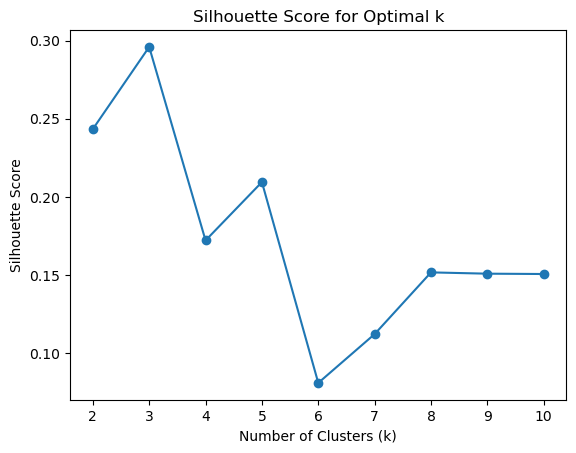

In [37]:
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_standardized)
    silhouette_scores.append(silhouette_score(data_standardized, labels))

# Plot silhouette scores
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

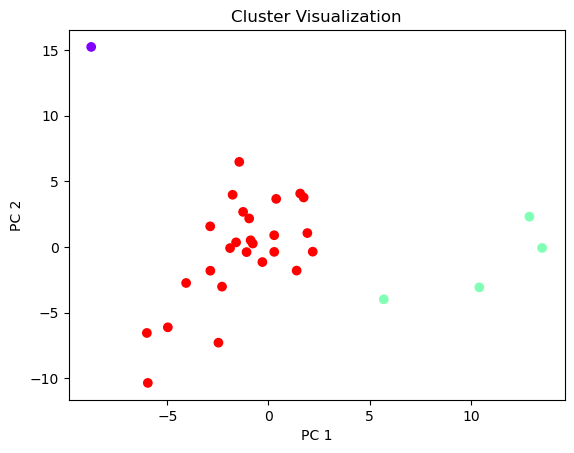

In [38]:

# Choose the number of components you want to retain
n_components = 2 
pca = PCA(n_components=n_components)
reduced_data = pca.fit_transform(data_standardized)

# Cluster
k = 3
# Apply k-means clustering
kmeans = KMeans(n_clusters=k, random_state=1234)
data_standardized['Cluster'] = kmeans.fit_predict(data_standardized)


plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=data_standardized['Cluster'], cmap='rainbow')
plt.title('Cluster Visualization')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

#### Weekly mean

In [39]:
band_values = []
ids = []
for i, geom in big_pv_geoms_32632.iterrows():
    try:
        data = xr.open_dataset(f"./data/netcdfs/S2_2022_{i}.nc",decode_coords="all")
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32632")
        clipped = data.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)
        clipped = clipped.where(~cloud_mask)
        aoi_mean = clipped.mean(dim=["x","y"],skipna=True).resample({"t": "W"}).mean() #Resampling to weekly, maybe required to align different time series
        #aoi_mean = clipped.mean(dim=["x","y"],skipna=True) # Computing the mean over the area which should be covered by the panels. Other statistics can be computed
        arr = aoi_mean.to_array().values[:11,]
        arr = arr.reshape(-1)
        band_values.append(arr)
        ids.append(i)
        #reshaped_arr = arr.reshape(-1)

    except:
        print(i)


800


In [40]:
bands = list(aoi_mean.to_array()['variable'].values[:11])

columns=[]
for b in bands:
    for t in range(53):
        columns.append(f'{b}_{t+1}')
        
        
data = pd.DataFrame(band_values, columns=columns)
data = data.fillna(-9999)

In [41]:
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data)
data_standardized = pd.DataFrame(data_standardized)

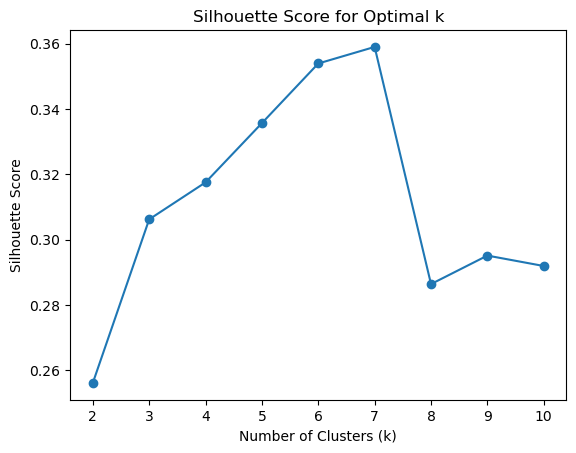

In [42]:
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_standardized)
    silhouette_scores.append(silhouette_score(data_standardized, labels))

# Plot silhouette scores
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

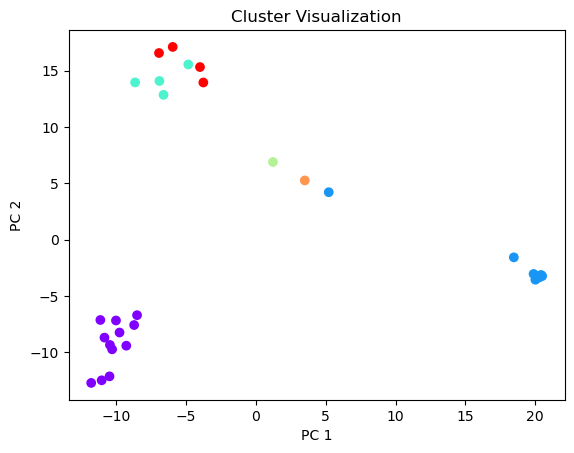

In [43]:
# Choose the number of components you want to retain
n_components = 2 
pca = PCA(n_components=n_components)
reduced_data = pca.fit_transform(data_standardized)

# Cluster
k = 6
# Apply k-means clustering
kmeans = KMeans(n_clusters=k, random_state=1234)
data_standardized['Cluster'] = kmeans.fit_predict(data_standardized)


plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=data_standardized['Cluster'], cmap='rainbow')
plt.title('Cluster Visualization')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

### Validation of OSM polygons based on DescartesLab result

In [44]:
for d in ['trn', 'cv', 'test']:
    gdf1 = gpd.read_file(f'data/descarteslab/{d}_polygons.json')
    big_pv_geoms_4326 = big_pv_geoms_32632.to_crs(4326)
    filtered_gdf = gpd.overlay(big_pv_geoms_4326, gdf1, how='intersection')
    print(f'Found {filtered_gdf.shape[0]} in {d} DescartesLab dataset')

Found 0 in trn DescartesLab dataset
Found 0 in cv DescartesLab dataset
Found 3 in test DescartesLab dataset


In [45]:
filtered_gdf

,id_1,land_cover,aoi_idx,aoi,id_2,NAME,ORGN_NAME,geometry
0,101.0,Grassland,106_14.304507694293548_47.004040661000914,106,NaN,Austria,Österreich,"POLYGON ((14.63158 47.18080, 14.63160 47.18086..."
1,159.0,Grassland,106_14.304507694293548_47.004040661000914,106,NaN,Austria,Österreich,"POLYGON ((14.39481 47.27290, 14.39481 47.27278..."
2,159.0,Grassland,106_14.304507694293548_47.004040661000914,106,NaN,Austria,Österreich,"POLYGON ((14.38957 47.27131, 14.38961 47.27176..."


In [46]:
filtered_gdf['centroid'] = filtered_gdf['geometry'].centroid
filtered_gdf

,id_1,land_cover,aoi_idx,aoi,id_2,NAME,ORGN_NAME,geometry,centroid
0,101.0,Grassland,106_14.304507694293548_47.004040661000914,106,NaN,Austria,Österreich,"POLYGON ((14.63158 47.18080, 14.63160 47.18086...",POINT (14.63195 47.18125)
1,159.0,Grassland,106_14.304507694293548_47.004040661000914,106,NaN,Austria,Österreich,"POLYGON ((14.39481 47.27290, 14.39481 47.27278...",POINT (14.39247 47.27229)
2,159.0,Grassland,106_14.304507694293548_47.004040661000914,106,NaN,Austria,Österreich,"POLYGON ((14.38957 47.27131, 14.38961 47.27176...",POINT (14.39003 47.27152)


In [47]:
## Plot over water
m = leafmap.Map(center=[48.42390, 15.76969], zoom=17,basemap="Esri.WorldImagery")
m.add_gdf(big_pv_geoms, layer_name="PV")
m

Map(center=[48.4239, 15.76969], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…